# Analyzing business potential of areas in Pune, India

### Table of contents

[1. Deciding initial search locations and getting their coordinates](#one)

[2. Searching for venues around areas with prospects (using Foursquare API)](#two)

[3. Visualizing all venues on map](#three)

[4. Clustering the venues](#four)

[5. Visualizing the clusters on map](#five)

[6. Analyzing the clusters](#six)

[7. Analyzing connectivity by road to business areas](#seven)

[8. Locating the banks and ATM's near business areas](#eight)

[9. Conclusion](#nine)

### Deciding initial search locations and getting their coordinates <a name="one"></a>

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim      # geolocation library
import requests                          # to handle requests to urls

#### Function to get coordinates from list of address

Using Nominatim() for geolocation from geopy library to get the value of latitude and longitude from address

In [2]:
def get_coordinates(address_list):
    geolocator = Nominatim(user_agent="wain")
    locations = pd.DataFrame(columns=['Area name', 'latitude', 'longitude'])
    for address in address_list:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        except:                                  # incase the address entered is not found, an exception will be thrown.
            latitude = 'Address not found'
            longitude = 'Address not found'
        locations = locations.append(
            {
                'Area name': address,
                'latitude': latitude,
                'longitude': longitude
            },
            ignore_index=True)
    return locations

#### Making a dataframe of locations around which to search for venues using Foursquare API

The areas I selected are surrounded by the most bustling business locations. I selected the first five locations in the list below initially, but not whole city of Pune was covered. So later I added 6th location.

In [3]:
# list of areas that I decided upon, venues around these locations will be used
address = ['Shankar Kalat nagar','Pimpri-Chinchwad','Aundh,Pune','Kothrud','Koregaon Park','Hadapsar']
locations = get_coordinates(address)
locations

,Area name,latitude,longitude
0,Shankar Kalat nagar,18.604093,73.754065
1,Pimpri-Chinchwad,18.627929,73.800983
2,"Aundh,Pune",18.561883,73.810196
3,Kothrud,18.503889,73.807673
4,Koregaon Park,18.537553,73.893925
5,Hadapsar,18.519805,73.934446


### Searching for venues around areas with prospects (using Foursquare API)<a name="two"></a>

#### Defining Foursquare credentials

In [4]:
# hide this cell
# credential foursquare API
CLIENT_ID = 'DMMNDCKP4HCEBKNG0OZUKP4HQ4G2ARKETXFJLZOI1DY001IT' # your Foursquare ID
CLIENT_SECRET = 'BNOTBJCDHCHRJ3Z1EAMLB0TXSCA4RUH1HSABRTIV33ERSMAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### A function to get list of venues around a coordinate

In [5]:
import json
from pandas.io.json import json_normalize

Using the Foursquare API to get list of venues around the coordinates passed

In [6]:
def get_venues(lat, lon):
    LIMIT = 100
    radius = 5000
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)  # flatten JSON
        filtered_columns = [
            'venue.name', 'venue.categories', 'venue.location.lat',
            'venue.location.lng'
        ]
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(
            get_category_type, axis=1)
        nearby_venues.columns = [
            col.split(".")[-1] for col in nearby_venues.columns
        ]

    except:
        return None

    return nearby_venues

####  Function that extracts the category of the venue-->   Function obtained from Foursquare lab.

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Making a dataframe containing the venues and their coordinates.

In [8]:
df_venues = pd.DataFrame(columns=['name','categories','lat','lng'])
for i in range (0,len(locations.index)):
    df_venues = df_venues.append(get_venues(locations.latitude[i],locations.longitude[i]))
    
df_venues.shape

(593, 4)

The index in dataframe will repeat starting from 0 for each of the six locations in the above loop. Hence there is a need to set the index in order

In [9]:
df_venues.reset_index(drop=True, inplace=True)
df_venues.head()

,name,categories,lat,lng
0,Sayaji,Hotel,18.599535,73.754995
1,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,Courtyard by Marriott,Hotel,18.591527,73.746831
4,Little Italy,Italian Restaurant,18.591513,73.743668


The radius for search around the initial locations was km. There was probability of same venues existing in the range of search radius from two areas. Therefore removing duplicate venue rows.

In [10]:
df_venues = df_venues.drop_duplicates()

It can be seen from the shape of the df_venues dataframe that there were some duplicate venues present. The initial number of rows where 594 and 488 rows after removing duplicates.

In [11]:
df_venues.shape

(487, 4)

### Visualizing all venues on map<a name="three"></a>

Using Folium library for plotting the venues

In [12]:
import folium

In [13]:
map_ = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, Categories, name in zip(df_venues['lat'], df_venues['lng'], df_venues['categories'], df_venues['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

In [14]:
df_venues.to_csv('venues_all.csv',index=False)   # exporting csv for tests

### Clustering the venues<a name="four"></a>

#### Preparing the dataset for clustering algorithm

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from folium import plugins
import matplotlib.pyplot as plt

Getting only the coordinates of the venues. Other columns like categories and name will only make it difficult to classify the data into clusters. I wanted the clusters to formed based on the locations only. This way it will be easy to identify the areas with good business prospects.

In [16]:
Clus_dataSet = df_venues[['lat','lng']] 
Clus_dataSet.head()

,lat,lng
0,18.599535,73.754995
1,18.591192,73.752440
2,18.599390,73.755090
3,18.591527,73.746831
4,18.591513,73.743668


Scaling the value of coordinates so that the algorithm clusters more accurately. If data is not scaled, the number of clusters is very low or only 1 cluster in some cases.

In [17]:
scaler = StandardScaler()
Clus_dataSet_scale = scaler.fit_transform(Clus_dataSet)
Clus_dataSet_scale[0:5]

array([[ 0.98668867, -1.31098468],
       [ 0.78919645, -1.3546089 ],
       [ 0.98323731, -1.30935999],
       [ 0.79713373, -1.45034577],
       [ 0.79679557, -1.5043403 ]])

#### Using K-means to cluster venues

I also tested the clusters using DBSCAN, the resulting clusters were good. There were 7 clusters but with some outliers. I would have had to process these outliers seperately or add them to the nearest clusters. The k-means also clustered them into 5 clusters with good distribution according to area. Though not as detailed as DBSCAN but I still decided to use K-means.

#### Finding the best K

In [18]:
dist = []
list_k = list(range(1, 12))      # list of values of k to test for

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet_scale)
    dist.append(km.inertia_)   

Using elbow method for finding best k

Text(0, 0.5, 'Sum of squared distance')

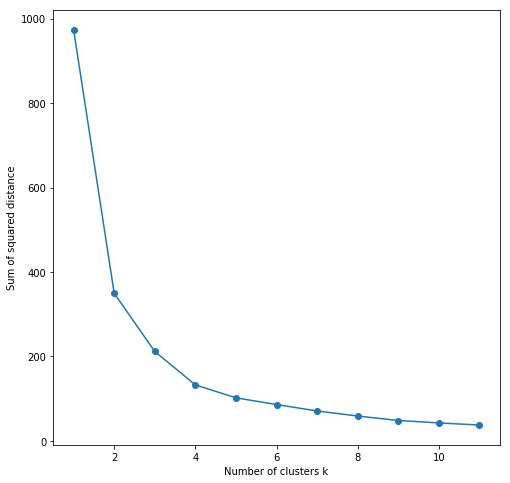

In [19]:
# Plot dist against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, dist, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

There is no proper elbow seen in the graph. So I decided to use k=5. The graph starts to straighten out after this point with almost no change in slope.

#### Fitting the data on K-means algorithm

In [20]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet_scale)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 4, 0, 2, 2, 0,
       2, 2, 4, 4, 0, 0, 4, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0,
       0, 0, 4, 2, 0, 2])

### Visualizing the clusters on map<a name="five"></a>

In [21]:
color_options = [
    'black', 'blue', 'red', 'purple', 'darkgreen', 'darkpurple',
    'darkred', 'gray', 'green', 'lightblue', 'lightgreen', 'lightred',
    'orange', 'pink'
]
map_clus = folium.Map(location=[locations.latitude[2], locations.longitude[2]],
                      zoom_start=11)
# add markers to map
for lat, lng, Categories, name, lab in zip(df_venues['lat'], df_venues['lng'],
                                           df_venues['categories'],
                                           df_venues['name'], labels):
    label = '{}, {}'.format(name, Categories, lab)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=1,
                        popup=label,
                        color=color_options[lab],
                        fill=True,
                        fill_opacity=1,
                        parse_html=False).add_to(map_clus)

map_clus

### Analyzing the clusters<a name="six"></a>

#### Adding Cluster labels column to separate dataframe according to cluster

In [22]:
df_venues.insert(0, 'Cluster Labels', labels)
df_venues.head()

,Cluster Labels,name,categories,lat,lng
0,0,Sayaji,Hotel,18.599535,73.754995
1,0,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,0,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,0,Courtyard by Marriott,Hotel,18.591527,73.746831
4,0,Little Italy,Italian Restaurant,18.591513,73.743668


#### Function for getting address from coordinates

Using Nominatim() from geopy library for reverse geolocation.

In [23]:
def get_address(coordinates_list):
    reverse_geolocator = Nominatim(user_agent="wain")
    area_name = []
    for coord in coordinates_list:
        try:
            address = reverse_geolocator.reverse(coord)
            x = str(address)
            area_name.append(x.split(',')[-6])
        except:
            x = 'Address not found'
            area_name.append(x)        
    return area_name

#### Preparing dataframe for Cluster with label 0

In [24]:
Cluster_0 = df_venues.loc[df_venues['Cluster Labels'] == 0]
Cluster_0.reset_index(drop=True, inplace=True)        # index will be taken from original df, hence need to reset index
Cluster_0.head()

,Cluster Labels,name,categories,lat,lng
0,0,Sayaji,Hotel,18.599535,73.754995
1,0,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,0,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,0,Courtyard by Marriott,Hotel,18.591527,73.746831
4,0,Little Italy,Italian Restaurant,18.591513,73.743668


Converting to list to get the area name from address

In [25]:
Cluster_0_coord = Cluster_0[['lat','lng']].values.tolist()
Cluster_0_coord[:5]

[[18.59953540618991, 73.7549952061101],
 [18.59119169262836, 73.75243955724582],
 [18.599389591869766, 73.75509038587762],
 [18.59152702926924, 73.74683097930983],
 [18.59151274236633, 73.74366780400008]]

Getting a list of area name for each venue using reverse geolocation

In [26]:
area_name = get_address(Cluster_0_coord)
area_name[:5]

[' Mhalunge', ' Mhalunge', ' Mhalunge', ' Mhalunge', ' Mhalunge']

In [27]:
Cluster_0.insert(0, 'Area_name', area_name)
Cluster_0.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Mhalunge,0,Sayaji,Hotel,18.599535,73.754995
1,Mhalunge,0,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,Mhalunge,0,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,Mhalunge,0,Courtyard by Marriott,Hotel,18.591527,73.746831
4,Mhalunge,0,Little Italy,Italian Restaurant,18.591513,73.743668


#### Preparing dataframes for clusters with labels 1,2,3 and 4

In [28]:
Cluster_1 = df_venues.loc[df_venues['Cluster Labels'] == 1]
Cluster_1.reset_index(drop=True, inplace=True)
Cluster_1_coord = Cluster_1[['lat','lng']].values.tolist()
area_name = get_address(Cluster_1_coord)
Cluster_1.insert(0, 'Area_name', area_name)
Cluster_1.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Model Colony,1,JW Marriott Hotel Pune,Hotel,18.532412,73.829842
1,Address not found,1,Spice Kitchen,Asian Restaurant,18.531887,73.829571
2,Model Colony,1,Paasha,Lounge,18.532077,73.829564
3,Model Colony,1,Pune Baking Company,Bakery,18.531972,73.829834
4,Model Colony,1,Crossword,Bookstore,18.534814,73.829770


In [29]:
Cluster_2 = df_venues.loc[df_venues['Cluster Labels'] == 2]
Cluster_2.reset_index(drop=True, inplace=True)
Cluster_2_coord = Cluster_2[['lat','lng']].values.tolist()
area_name = get_address(Cluster_2_coord)
Cluster_2.insert(0, 'Area_name', area_name)
Cluster_2.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Mhalunge,2,Urban Foundry,Lounge,18.569289,73.774725
1,Address not found,2,Incognito,Italian Restaurant,18.570376,73.774607
2,Balewadi,2,CopaCabana,Indian Restaurant,18.589074,73.782483
3,Balewadi,2,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514
4,Mhalunge,2,Way Down South,South Indian Restaurant,18.566366,73.770707


In [30]:
Cluster_3 = df_venues.loc[df_venues['Cluster Labels'] == 3]
Cluster_3.reset_index(drop=True, inplace=True)
Cluster_3_coord = Cluster_3[['lat','lng']].values.tolist()
area_name = get_address(Cluster_3_coord)
Cluster_3.insert(0, 'Area_name', area_name)
Cluster_3.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Ghorpuri,3,Malaka Spice,Asian Restaurant,18.537519,73.897719
1,Ghorpuri,3,Dario's Restaurant,Italian Restaurant,18.537207,73.888813
2,Ghorpuri,3,the French Window Patisserie,Bakery,18.537709,73.897990
3,Ghorpuri,3,Squisito,Italian Restaurant,18.536395,73.897193
4,Somwar Peth,3,Conrad Pune,Hotel,18.535020,73.883056


In [31]:
Cluster_4 = df_venues.loc[df_venues['Cluster Labels'] == 4]
Cluster_4.reset_index(drop=True, inplace=True)
Cluster_4_coord = Cluster_4[['lat','lng']].values.tolist()
area_name = get_address(Cluster_4_coord)
Cluster_4.insert(0, 'Area_name', area_name)
Cluster_4.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Chinchwad,4,Nevale Misal,Fast Food Restaurant,18.627925,73.780808
1,Punawale,4,Bakers Hut,Bakery,18.642342,73.773437
2,Chinchwad,4,Hotel Arihant,Snack Place,18.626813,73.782451
3,Punawale,4,Natural Ice Cream,Ice Cream Shop,18.642399,73.773437
4,Ravet,4,D Mart,Convenience Store,18.646531,73.756541


#### Function to get the top ten venues in each area of a cluster

In [32]:
def get_top_venues(cluster_venues):
    # one hot encoding
    cluster_onehot = pd.get_dummies(cluster_venues[['categories']], prefix="", prefix_sep="")

    # add area name column back to dataframe
    cluster_onehot['Area_name'] = cluster_venues['Area_name'] 

    # move neighborhood column to the first column
    fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
    cluster_onehot = cluster_onehot[fixed_columns]
    cluster_grouped = cluster_onehot.groupby('Area_name').mean().reset_index()
    
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Area_name']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    area_venues_sorted = pd.DataFrame(columns=columns)
    area_venues_sorted['Area_name'] = cluster_grouped['Area_name']

    for ind in np.arange(cluster_grouped.shape[0]):
        area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

    return area_venues_sorted

Function to sort venues in descending order

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Analyzing cluster 0

Visualizing Cluster 0 on map

In [38]:
map_0 = folium.Map(location=[Cluster_0['lat'][0], Cluster_0['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_0['lat'], Cluster_0['lng'], Cluster_0['categories'], Cluster_0['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_0)  
    
map_0

It can be seen on the map that areas Pimple saudagar, Pimple nilakh, balewadi, Aundh and Pashan fall under cluster_0.

In [39]:
Cluster_0_top_venues = get_top_venues(Cluster_0)
Cluster_0_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mhalunge,Hotel,Indian Restaurant,Café,Sandwich Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Chinese Restaurant,Department Store,Diner
1,Nande,Pizza Place,Food Court,Coffee Shop,Indian Restaurant,Vegetarian / Vegan Restaurant,IT Services,Café,Chinese Restaurant,Department Store,Diner
2,Punawale,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,IT Services,Café,Chinese Restaurant,Coffee Shop,Department Store,Diner,Electronics Store
3,Thergaon,Hotel,Sandwich Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,IT Services,Café,Chinese Restaurant,Coffee Shop,Department Store,Diner


It can be seen that there are 10 different areas in CLuster_0. All the most common venues can be seen according to area.

In [40]:
Cluster_0.categories.nunique()

26

In [41]:
Cluster_0.categories.value_counts()

Indian Restaurant                 8
Hotel                             8
Fast Food Restaurant              5
Sandwich Place                    3
Café                              3
Food Court                        2
Pizza Place                       2
Mexican Restaurant                1
Electronics Store                 1
Lounge                            1
Diner                             1
Coffee Shop                       1
Department Store                  1
Vegetarian / Vegan Restaurant     1
Motel                             1
Italian Restaurant                1
Ice Cream Shop                    1
BBQ Joint                         1
Chinese Restaurant                1
Snack Place                       1
Multicuisine Indian Restaurant    1
IT Services                       1
Multiplex                         1
Restaurant                        1
Tea Room                          1
Food Truck                        1
Name: categories, dtype: int64

#### Analyzing cluster 1

In [42]:
map_1 = folium.Map(location=[Cluster_1['lat'][0], Cluster_1['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_1['lat'], Cluster_1['lng'], Cluster_1['categories'], Cluster_1['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_1)  
    
map_1

In [43]:
Cluster_1_top_venues = get_top_venues(Cluster_1)
Cluster_1_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bavdhan Budruk,Sandwich Place,Café,Chaat Place,Coffee Shop,Gym,Garden,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop
1,Chandani Chowk,Indian Restaurant,Vegetarian / Vegan Restaurant,History Museum,Gym,Garden,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop,Dessert Shop
2,Dattawadi,Garden,Vegetarian / Vegan Restaurant,Trail,Gym / Fitness Center,Gym,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop,Dessert Shop
3,Deccan Gymkhana,Vegetarian / Vegan Restaurant,Frozen Yogurt Shop,Bistro,Indian Restaurant,South Indian Restaurant,Snack Place,Fast Food Restaurant,Donut Shop,Sandwich Place,Coffee Shop
4,Erandwana,Snack Place,Pizza Place,Trail,Bakery,Bistro,Breakfast Spot,Burger Joint,Café,Seafood Restaurant,Sandwich Place
5,Karve Nagar,Ice Cream Shop,Gym / Fitness Center,Gym,Café,Deli / Bodega,Garden,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop
6,Kothrud,Café,Vegetarian / Vegan Restaurant,Ice Cream Shop,French Restaurant,Fast Food Restaurant,Dessert Shop,Other Great Outdoors,Chinese Restaurant,Pub,South Indian Restaurant
7,Model Colony,Lounge,Chinese Restaurant,Coffee Shop,Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Nightclub,Bakery,Bistro,Bookstore
8,Narayan Peth,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Gym,Garden,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop
9,Navi Peth,Snack Place,Vegetarian / Vegan Restaurant,Coffee Shop,Gym,Garden,Frozen Yogurt Shop,French Restaurant,Fast Food Restaurant,Donut Shop,Dessert Shop


In [44]:
Cluster_1.categories.nunique()

44

In [45]:
Cluster_0.categories.value_counts()

Indian Restaurant                 8
Hotel                             8
Fast Food Restaurant              5
Sandwich Place                    3
Café                              3
Food Court                        2
Pizza Place                       2
Mexican Restaurant                1
Electronics Store                 1
Lounge                            1
Diner                             1
Coffee Shop                       1
Department Store                  1
Vegetarian / Vegan Restaurant     1
Motel                             1
Italian Restaurant                1
Ice Cream Shop                    1
BBQ Joint                         1
Chinese Restaurant                1
Snack Place                       1
Multicuisine Indian Restaurant    1
IT Services                       1
Multiplex                         1
Restaurant                        1
Tea Room                          1
Food Truck                        1
Name: categories, dtype: int64

#### Analyzing cluster 2

In [46]:
map_2 = folium.Map(location=[Cluster_2['lat'][0], Cluster_2['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_2['lat'], Cluster_2['lng'], Cluster_2['categories'], Cluster_2['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_2)  
    
map_2

In [47]:
Cluster_2_top_venues = get_top_venues(Cluster_2)
Cluster_2_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aundh,Bakery,Gym,Ice Cream Shop,Indian Restaurant,Café,Lounge,English Restaurant,Dessert Shop,Coffee Shop,Grocery Store
1,Balewadi,Indian Restaurant,American Restaurant,Chinese Restaurant,Liquor Store,Café,Food Truck,Snack Place,Asian Restaurant,English Restaurant,Donut Shop
2,Baner,Indian Restaurant,Malay Restaurant,Café,Snack Place,Dessert Shop,South Indian Restaurant,Pizza Place,Ice Cream Shop,Breakfast Spot,Molecular Gastronomy Restaurant
3,Bavdhan Budruk,Ice Cream Shop,Indian Restaurant,Beer Garden,Stadium,Chinese Restaurant,English Restaurant,Donut Shop,Diner,Dessert Shop,Department Store
4,Kasarwadi,Restaurant,Indian Restaurant,Food Truck,Stadium,Chinese Restaurant,English Restaurant,Donut Shop,Diner,Dessert Shop,Department Store
5,Mhalunge,Fast Food Restaurant,Indian Restaurant,Stadium,Lounge,Asian Restaurant,Bar,Breakfast Spot,Brewery,Café,Coffee Shop
6,Pashan,Fast Food Restaurant,Chinese Restaurant,BBQ Joint,Bakery,Coffee Shop,Stadium,English Restaurant,Donut Shop,Diner,Dessert Shop
7,Pimple Nilakh,Recreation Center,Stadium,Café,English Restaurant,Donut Shop,Diner,Dessert Shop,Department Store,Coffee Shop,Chocolate Shop
8,Pimple Saudagar,Café,Fast Food Restaurant,Sandwich Place,Pizza Place,Ice Cream Shop,Indian Restaurant,American Restaurant,Shopping Mall,Restaurant,North Indian Restaurant
9,Address not found,Indian Restaurant,Italian Restaurant,Bistro,Lounge,Stadium,Chinese Restaurant,Donut Shop,Diner,Dessert Shop,Department Store


In [48]:
Cluster_2.categories.nunique()

44

In [153]:
Cluster_2.categories.value_counts()

Indian Restaurant                9
Pizza Place                      6
Fast Food Restaurant             4
Café                             4
Hotel                            3
Snack Place                      3
Gym                              2
Ice Cream Shop                   2
Train Station                    2
Coffee Shop                      2
Gym / Fitness Center             2
Asian Restaurant                 2
Dance Studio                     1
Middle Eastern Restaurant        1
Chinese Restaurant               1
Convenience Store                1
Restaurant                       1
Shopping Mall                    1
Breakfast Spot                   1
Multiplex                        1
Bookstore                        1
Thai Restaurant                  1
Mexican Restaurant               1
Hotel Bar                        1
Bakery                           1
Diner                            1
Vegetarian / Vegan Restaurant    1
Sandwich Place                   1
Italian Restaurant  

#### Analyzing cluster 3

In [49]:
map_3 = folium.Map(location=[Cluster_3['lat'][0], Cluster_3['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_3['lat'], Cluster_3['lng'], Cluster_3['categories'], Cluster_3['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_3)  
    
map_3

In [50]:
Cluster_3_top_venues = get_top_venues(Cluster_3)
Cluster_3_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fatima Nagar,Electronics Store,Yoga Studio,Vegetarian / Vegan Restaurant,Ice Cream Shop,Hotel Bar,Hotel,Gym / Fitness Center,Gym,Golf Course,French Restaurant
1,Ganesh Peth,Food Truck,Yoga Studio,Vegetarian / Vegan Restaurant,Ice Cream Shop,Hotel Bar,Hotel,Gym / Fitness Center,Gym,Golf Course,French Restaurant
2,Ghorpuri,Café,Bakery,Italian Restaurant,Brewery,Restaurant,Yoga Studio,Pub,Ice Cream Shop,French Restaurant,Lounge
3,Hadapsar,Donut Shop,Multiplex,Coffee Shop,Indian Restaurant,Sandwich Place,Italian Restaurant,Chinese Restaurant,Bar,Ice Cream Shop,BBQ Joint
4,Kalyani Nagar,Indian Restaurant,Lounge,Pub,Italian Restaurant,Hotel,Nightclub,Gym / Fitness Center,Motel,Jazz Club,Indian Chinese Restaurant
5,Kharadi,Hotel,Yoga Studio,Vegetarian / Vegan Restaurant,Ice Cream Shop,Hotel Bar,Gym / Fitness Center,Gym,Golf Course,French Restaurant,Food Truck
6,Mangalwar Peth,Hotel,Yoga Studio,Vegetarian / Vegan Restaurant,Ice Cream Shop,Hotel Bar,Gym / Fitness Center,Gym,Golf Course,French Restaurant,Food Truck
7,Mundhwa,Indian Restaurant,Beach Bar,Brewery,Multicuisine Indian Restaurant,Food Truck,Dim Sum Restaurant,Donut Shop,Electronics Store,Fast Food Restaurant,French Restaurant
8,Pune Cantonment,Indian Restaurant,Sports Bar,Fast Food Restaurant,Café,Racetrack,Plaza,Bar,Bakery,Department Store,Hotel
9,Somwar Peth,Indian Restaurant,Seafood Restaurant,Gym,Kebab Restaurant,Lounge,Movie Theater,Breakfast Spot,Chinese Restaurant,Hotel,Bar


In [51]:
Cluster_3.categories.nunique()

64

In [152]:
Cluster_3.categories.value_counts()

Hotel                             8
Indian Restaurant                 7
Fast Food Restaurant              6
Sandwich Place                    3
Café                              3
Pizza Place                       2
Food Court                        2
Electronics Store                 1
Restaurant                        1
Tea Room                          1
Chinese Restaurant                1
Department Store                  1
Multicuisine Indian Restaurant    1
Ice Cream Shop                    1
Snack Place                       1
BBQ Joint                         1
Mexican Restaurant                1
Multiplex                         1
Motel                             1
Diner                             1
Lounge                            1
Coffee Shop                       1
Italian Restaurant                1
Vegetarian / Vegan Restaurant     1
IT Services                       1
Food Truck                        1
Name: categories, dtype: int64

#### Analyzing cluster 4

In [52]:
map_4 = folium.Map(location=[Cluster_4['lat'][0], Cluster_4['lng'][0]], zoom_start=14)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_4['lat'], Cluster_4['lng'], Cluster_4['categories'], Cluster_4['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_4)  
    
map_4

In [53]:
Cluster_4_top_venues = get_top_venues(Cluster_4)
Cluster_4_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chinchwad,Indian Restaurant,Pizza Place,Train Station,Snack Place,Bookstore,Hotel,Café,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Diner
1,Kasarwadi,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Train Station,Bakery,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop,Convenience Store
2,Nigdi,Hotel Bar,Vegetarian / Vegan Restaurant,Gym,Bakery,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop,Convenience Store
3,Pimpri,Gym / Fitness Center,Breakfast Spot,Market,Gym,Bakery,Bookstore,Café,Chinese Restaurant,Coffee Shop,Convenience Store
4,Pimpri-Chinchwad,Indian Restaurant,Gym / Fitness Center,Multiplex,Electronics Store,Ice Cream Shop,Dance Studio,Coffee Shop,Gym,Chinese Restaurant,Food & Drink Shop
5,Punawale,Mexican Restaurant,Thai Restaurant,Snack Place,Bakery,Café,Ice Cream Shop,Convenience Store,Electronics Store,Diner,Dessert Shop
6,Ravet,Indian Restaurant,Asian Restaurant,Café,Pizza Place,Coffee Shop,Convenience Store,Diner,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant
7,Sudershan Nagar,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Convenience Store,Fast Food Restaurant,Electronics Store,Diner,Dessert Shop,Dance Studio,Coffee Shop
8,Thergaon,Shopping Mall,Vegetarian / Vegan Restaurant,Gym,Bakery,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop,Convenience Store
9,Ajmera,Dessert Shop,Food & Drink Shop,Vegetarian / Vegan Restaurant,Train Station,Bakery,Bookstore,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop


In [54]:
Cluster_4.categories.nunique()

32

In [154]:
Cluster_4.categories.value_counts()

Indian Restaurant                12
Café                              8
Vegetarian / Vegan Restaurant     6
Coffee Shop                       6
Fast Food Restaurant              5
Ice Cream Shop                    5
Chinese Restaurant                4
Snack Place                       4
Seafood Restaurant                4
Gym                               3
Bakery                            3
Sandwich Place                    3
Bistro                            3
Lounge                            3
Italian Restaurant                3
Gym / Fitness Center              2
South Indian Restaurant           2
Juice Bar                         2
Dessert Shop                      2
Theater                           2
Trail                             2
Asian Restaurant                  2
BBQ Joint                         1
Shopping Mall                     1
Garden                            1
Tea Room                          1
Mountain                          1
Stationery Store            

###  Analyzing connectivity by road to business areas<a name="seven"></a>

From the data of bus stops and bus routes , it is possible to check public transport connectivity to the potential areas. There were more than 5500 bus stops in and around the city of Pune available in the data. Only those stops which are around the clusters need to be analyzed.

#### Importing stops dataframe and cleaning it

In [156]:
df_stops = pd.read_csv('stops.csv')
df_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,32769,151131,Forest Office Road,NaN,18.51983,73.63158,NaN,NaN,NaN,NaN,NaN,NaN
1,32770,152339,Kusalkar Putala,NaN,18.52889,73.82708,NaN,NaN,NaN,NaN,NaN,NaN
2,32771,154648,Tower Line,NaN,18.67007,73.78613,NaN,NaN,NaN,NaN,NaN,NaN
3,32772,153069,Nehrunagar Depot,NaN,18.62930,73.81942,NaN,NaN,NaN,NaN,NaN,NaN
4,32773,151724,Jagtap Chowk,NaN,18.49153,73.90019,NaN,NaN,NaN,NaN,NaN,NaN


Checking whether there are any null values in the needed columns before dropping NaN

In [157]:
df_stops[['stop_lat','stop_lon']].isna().any()

stop_lat    False
stop_lon    False
dtype: bool

In [158]:
df_stops.shape

(5624, 12)

In [159]:
df_stops.dropna(axis=1,inplace=True)
df_stops.drop(columns=['stop_code','stop_id'],inplace=True)
print(df_stops.shape)
df_stops.head()

(5624, 3)


,stop_name,stop_lat,stop_lon
0,Forest Office Road,18.51983,73.63158
1,Kusalkar Putala,18.52889,73.82708
2,Tower Line,18.67007,73.78613
3,Nehrunagar Depot,18.62930,73.81942
4,Jagtap Chowk,18.49153,73.90019


#### Removing stops which are not in range of radius of 5km from cluster centers

In [160]:
from geopy import distance    # to calculate distance between two coordinates.

Making a list of cluster centers and bus stop coordinates to calculate distance between stops and centers.

In [161]:
test_point_list = df_stops[['stop_lat','stop_lon']].values.tolist()
test_point_list[:5]

[[18.51983, 73.63158],
 [18.52889, 73.82708000000001],
 [18.670070000000003, 73.78613],
 [18.6293, 73.81942],
 [18.491529999999997, 73.90019000000001]]

In [162]:
center_point_list = center_coord.values.tolist()
center_point_list[:5]

[[18.56930805697316, 73.78186532743666],
 [18.53446645624323, 73.89975061647455],
 [18.64021188847298, 73.79182698615519],
 [18.592693558984053, 73.74208268396602],
 [18.514029983480278, 73.82874953293054]]

Finding coordinates of bus stops inside search radius

In [163]:
radius = 3
stops_bool = [0 for i in range(len(test_point_list))]
for i in range(0,len(center_point_list)):
    for j in range(0,len(test_point_list)):
        dis = distance.distance(center_point_list[i], test_point_list[j]).km
        if dis < radius and stops_bool[j]==0:
            stops_bool[j] = 1
        
df_stops.insert(0,'stops_bool',stops_bool)
df_stops.head()

,stops_bool,stop_name,stop_lat,stop_lon
0,0,Forest Office Road,18.51983,73.63158
1,1,Kusalkar Putala,18.52889,73.82708
2,0,Tower Line,18.67007,73.78613
3,0,Nehrunagar Depot,18.62930,73.81942
4,0,Jagtap Chowk,18.49153,73.90019


In [164]:
stops_in_range = df_stops.loc[df_stops['stops_bool']==1]
print(stops_in_range.shape)
stops_in_range.drop(columns=['stops_bool'],inplace=True)
stops_in_range.reset_index(drop=True, inplace=True)
stops_in_range.head()

(1342, 4)


C:\Users\vae3\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,stop_name,stop_lat,stop_lon
0,Kusalkar Putala,18.52889,73.82708
1,Masulkar Colony,18.63368,73.80691
2,Bedekar Ganpati Mandir,18.51154,73.81720
3,Bhandarkar Road,18.51485,73.82880
4,Budhrani Hospital,18.53300,73.88619


#### Preparing a dataframe of cluster center coordinates

In [165]:
cluster_centres = kmeans.cluster_centers_
cluster_centres

array([[ 0.32212752, -0.70016056],
       [-0.54060431,  1.23322698],
       [ 1.92688671, -0.72392735],
       [ 0.86095677, -1.50274035],
       [-0.99516366, -0.05156486]])

To get the coordinates of the cluster centers I thought of two possible ways. One way was to inverse transform the scaled values from the dataset used to train K-means. But then the coordinates wont be any of the locations of the venues. Second way was to get the coordinate of the venue nearest to the cluster centers. KDtree from scipy library can be used to find the point closest to cluster centers.

In [166]:
from scipy import spatial

Getting the row index of the coordinates of the venues closest to cluster centers.

In [167]:
idx = []
for i in range(0,len(cluster_centres)):
    dist,index = spatial.KDTree(Clus_dataSet_scale).query(cluster_centres[i])
    idx.append(index)
idx

[73, 335, 104, 11, 256]

Getting the coordinates of venues from the index

In [168]:
center_coord = Clus_dataSet.iloc[idx][['lat','lng']]
center_coord

,lat,lng
73,18.569308,73.781865
403,18.534466,73.899751
105,18.640212,73.791827
11,18.592694,73.742083
306,18.514030,73.828750


#### Visualizing bus stops around cluster centers on map

In [169]:
map_bus = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, name in zip(stops_in_range['stop_lat'], stops_in_range['stop_lon'], stops_in_range['stop_name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_bus)

for lat, lng in zip(center_coord.lat, center_coord.lng):
    folium.Marker(
        location=[lat, lng],
        icon=None).add_to(map_bus)
    
map_bus

### Locating the banks and ATM's near business areas<a name="eight"></a>

#### Importing and cleaning ATM dataframe

In [124]:
df_atm = pd.read_excel('ATM.xlsx')
df_atm.head()

,name,address,class,longitude,latitude
0,Dena Bank ATM,"42, Narayandas Nagindas Gandhi Road, Pandurang...",ATM,73.825815,18.504604
1,Bank of India ATM,"Hadapsar Industrial Estate, Hadapsar, Pune, Ma...",ATM,73.918780,18.506822
2,HDFC Bank,"Sahakar Nagar, Shop No. 24 Ashoka Centre, Opp ...",ATM,73.857492,18.487281
3,Cosmos Bank ATM,"128/2, Warje Malwadi Rd, Mayur Colony, Kothrud...",ATM,73.820488,18.503669
4,yerawada bank atm,yerawada,ATM,73.868084,18.597894


In [125]:
df_atm.drop('class',axis=1,inplace=True)
df_atm.head()

,name,address,longitude,latitude
0,Dena Bank ATM,"42, Narayandas Nagindas Gandhi Road, Pandurang...",73.825815,18.504604
1,Bank of India ATM,"Hadapsar Industrial Estate, Hadapsar, Pune, Ma...",73.918780,18.506822
2,HDFC Bank,"Sahakar Nagar, Shop No. 24 Ashoka Centre, Opp ...",73.857492,18.487281
3,Cosmos Bank ATM,"128/2, Warje Malwadi Rd, Mayur Colony, Kothrud...",73.820488,18.503669
4,yerawada bank atm,yerawada,73.868084,18.597894


#### Importing and cleaning banks dataframe

In [129]:
df_bank = pd.read_excel('Banks.xlsx')
df_bank.head()

,name,address,class,longitude,latitude
0,Corporation Bank,"Sai Ganesh Complex,, Ganesh Nagar, Pune, Mahar...",Bank,73.821709,18.491709
1,"ICICI Bank Raviwar Peth, Pune - Branch & ATM","455/46,raviwar peth,p.b. no.581, Phadke houd, ...",Bank,73.859727,18.518498
2,Dena Bank,"Pb No. 307, Paras Estate, Navi Peth, Pune, Mah...",Bank,73.855427,18.510877
3,Janata Sahakari Bank Limited,"Office No-754, Vinayak Apartment, 1732, Tilak ...",Bank,73.851167,18.513385
4,Orient Bank Of Commerce,"Flat No 5, Sarita Kaksh, S No 588/2, Bibwewadi...",Bank,73.856769,18.520508


In [130]:
df_bank.drop('class',axis=1,inplace=True)
df_bank.head()

,name,address,longitude,latitude
0,Corporation Bank,"Sai Ganesh Complex,, Ganesh Nagar, Pune, Mahar...",73.821709,18.491709
1,"ICICI Bank Raviwar Peth, Pune - Branch & ATM","455/46,raviwar peth,p.b. no.581, Phadke houd, ...",73.859727,18.518498
2,Dena Bank,"Pb No. 307, Paras Estate, Navi Peth, Pune, Mah...",73.855427,18.510877
3,Janata Sahakari Bank Limited,"Office No-754, Vinayak Apartment, 1732, Tilak ...",73.851167,18.513385
4,Orient Bank Of Commerce,"Flat No 5, Sarita Kaksh, S No 588/2, Bibwewadi...",73.856769,18.520508


#### Visualizing banks and atm on map

In [131]:
map_atm = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers for atm to map
for lat, lng, name, addr in zip(df_atm['latitude'], df_atm['longitude'], df_atm['name'],df_atm['address']):
    label = '{},{}'.format(name,addr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_atm)

# add markers for banks on map
for lat, lng, name, addr in zip(df_bank['latitude'], df_bank['longitude'], df_bank['name'],df_bank['address']):
    label = '{},{}'.format(name,addr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='purple',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_atm)

# add markers for cluster centers on map
for lat, lng in zip(center_coord.lat, center_coord.lng):
    folium.Marker(
        location=[lat, lng],
        icon=None).add_to(map_atm)
    
map_atm

### Conclusion<a name="nine"></a>

(Note: The analysis and the results are highly dependent on the venues data provided by Foursquare API. The results might not be accurate and be different from what the actual scenario is in the real world. The conclusion reached from the analysis although can be accurate if there is more information about venues)

#### Analysis of clusters:
Looking at the locations covered by the clusters, it can be said that all the most popular areas for business are covered. The clusters formed are also satisfactory and are separated according to how the areas are perceived by people.

From the dataframes showing the top venues in each cluster, the popularity of different categories of business can be seen. The data shows a general trend that Restaurant is the category that is found to be popular in many of the areas.
The restaurants in these areas either have a unique theme or are a franchisee of a renowned brand.

Other categories like gym, snack places and fast food shops are runner ups in popularity.

#### Selecting category of new business
If the question is - which category of business would be best? There is no category that can be said to be the one having the best prospects. As it was seen that restaurant was the category with highest hits, each one of those in the area they are popular in had unique themes or associated with a brand. So having a unique idea for a new restaurant is advisable in case you are looking for healthy competition.
If one does not want competition, categories having the least number of businesses are a good option. 

#### Selecting the area and cluster region

This step should be done after selecting the category. It can be seen that all the areas in each cluster have varying categories. So there is no case where only a particular category of business will flourish.
Although there are many criteria like capital, nearby residential areas and other things to consider, there is a trend found in the data.
For e.g. if one plans to open a restaurant, food place or similar categories, the areas under cluster_0 have the most of these categories making competition tough but also means good customer base.
Similar conclusions can be drawn based on selected categories.
Other criteria can be the availability of transport and connectivity. Based on the number of bus stops and their location the areas can be shortlisted.
The availability of banks and ATMs can also be seen on the map.